# Thanks to https://www.kaggle.com/siavrez/wavenet-keras and Sergey Bryansky.
# You can take a look at Sergey's kernel [here](https://www.kaggle.com/sggpls/shifted-rfc-pipeline) or [here](https://www.kaggle.com/sggpls/wavenet-with-shifted-rfc-proba). Also, Sergey's [data is here.](https://www.kaggle.com/sggpls/ion-shifted-rfc-proba)

In [1]:
!pip install tensorflow_addons
import tensorflow as tf
from tensorflow.keras.layers import *
import pandas as pd
import numpy as np
import random
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping, TensorBoard
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import losses, models, optimizers
import tensorflow_addons as tfa
import gc
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# configurations and main hyperparammeters
EPOCHS = 180
NNBATCHSIZE = 16
GROUP_BATCH_SIZE = 4000
SEED = 321
LR = 0.001
SPLITS = 5

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [3]:
def Classifier(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    
    inp = Input(shape = (shape_))

    x = cbr(inp, 64, 16, 2, 1)
    x = cbr(x, 128, 8, 2, 1)
    
    x = cbr(x, 256, 8, 2, 1)
    x = cbr(x, 512, 4, 2, 1)
    
    x = cbr(x, 512, 4, 2, 1)

    x = Flatten()(x)
    x = Dense(512)(x)
    x = Dense(128)(x)
    
    enc = Dense(32)(x)
    
    x = Dense(128)(enc)
    x = Dense(512)(x)
    x = Dense(125 * 512)(x)
    x = Reshape((1, 125,512))(x)
    
    x = Conv2DTranspose(filters=512, strides=(1,2), kernel_size=(1, 4), padding='same')(x)

    
    x = Conv2DTranspose(filters=256, strides=(1,2), kernel_size=(1, 4), padding='same')(x)
    x = Conv2DTranspose(filters=128, strides=(1,2), kernel_size=(1,8), padding='same')(x)
    
    x = Conv2DTranspose(filters=64, strides=(1,2), kernel_size=(1, 8), padding='same')(x)
    x = Conv2DTranspose(filters=1,strides=(1,2), kernel_size=(1,16), padding='same')(x)

    autoenc = x = Reshape((4000,1))(x)
    
    
    encoder = models.Model(inputs = inp, outputs = enc)
    
    autoencoder = models.Model(inputs = inp, outputs = autoenc)
    opt = tfa.optimizers.SWA(Adam(lr = LR))
    autoencoder.compile(loss = 'mse', optimizer = opt)
    
    return autoencoder, encoder

Classifier((4000, 1))[0].summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2000, 64)          1088      
_________________________________________________________________
batch_normalization (BatchNo (None, 2000, 64)          256       
_________________________________________________________________
activation (Activation)      (None, 2000, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 128)         65664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 1000, 128)         0   

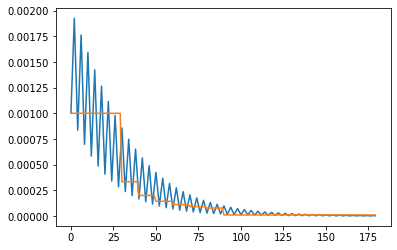

In [4]:
 def previous_lr_schedule(epoch):
    if epoch < 30:
        lr = LR
    elif epoch < 40:
        lr = LR / 3
    elif epoch < 50:
        lr = LR / 5
    elif epoch < 60:
        lr = LR / 7
    elif epoch < 70:
        lr = LR / 9
    elif epoch < 80:
        lr = LR / 11
    elif epoch < 90:
        lr = LR / 13
    else:
        lr = LR / 100
    return lr

def base_lr_schedule(epoch):
    return LR*0.956**epoch

def lr_schedule(epoch):
    base_lr = base_lr_schedule(epoch)
    max_lr = 0.002
    step_size = 2
    gamma = 0.965
    cycle = np.floor(1+epoch/(2*step_size))
    x = np.abs(epoch/step_size - 2*cycle + 1)
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))*gamma**(epoch)
    return lr


plt.plot([lr_schedule(i) for i in range(180)])
plt.plot([previous_lr_schedule(i) for i in range(180)]);

In [5]:
# read data
def read_data():
    train = pd.read_csv('../input/data-without-drift/train_clean.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
    test  = pd.read_csv('../input/data-without-drift/test_clean.csv', dtype={'time': np.float32, 'signal': np.float32})
    sub  = pd.read_csv('../input/liverpool-ion-switching/sample_submission.csv', dtype={'time': np.float32})
        
    return train, test, sub

# create batches of 4000 observations
def batching(df, batch_size):
    df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
    return df

# normalize the data (standard scaler). We can also try other scalers for a better score!
def normalize(train, test):
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal - train_input_mean) / train_input_sigma
    test['signal'] = (test.signal - train_input_mean) / train_input_sigma
    return train, test

# get lead and lags features
def lag_with_pct_change(df, windows):
    for window in windows:    
        df['signal_shift_pos_' + str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
        df['signal_shift_neg_' + str(window)] = df.groupby('group')['signal'].shift(-1 * window).fillna(0)
    return df

# main module to run feature engineering. Here you may want to try and add other features and check if your score imporves :).
def run_feat_engineering(df, batch_size):
    # create batches
    df = batching(df, batch_size = batch_size)
    return df

# fillna with the mean and select features for training
def feature_selection(train, test):
    features = [col for col in train.columns if col not in ['index', 'group', 'open_channels', 'time']]
    train = train.replace([np.inf, -np.inf], np.nan)
    test = test.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        feature_mean = pd.concat([train[feature], test[feature]], axis = 0).mean()
        train[feature] = train[feature].fillna(feature_mean)
        test[feature] = test[feature].fillna(feature_mean)
    return train, test, features


# main function to perfrom groupkfold cross validation (we have 1000 vectores of 4000 rows and 8 features (columns)). Going to make 5 groups with this subgroups.
def run_cv_model_by_batch(train, test, splits, batch_col, feats, sample_submission, nn_epochs, nn_batch_size):
    
    seed_everything(SEED)
    K.clear_session()
    config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
    tf.compat.v1.keras.backend.set_session(sess)
    oof_ = np.zeros((len(train)//GROUP_BATCH_SIZE, 32)) # build out of folds matrix with 11 columns, they represent our target variables classes (from 0 to 10)
    preds_ = np.zeros((len(test)//GROUP_BATCH_SIZE, 32))
    target = ['open_channels']
    group = train['group']
    kf = GroupKFold(n_splits=5)
    splits = [x for x in kf.split(train, train[target], group)]

    new_splits = []
    for sp in splits:
        new_split = []
        new_split.append(np.unique(group[sp[0]]))
        new_split.append(np.unique(group[sp[1]]))
        new_split.append(sp[1])    
        new_splits.append(new_split)
    # pivot target columns to transform the net to a multiclass classification estructure (you can also leave it in 1 vector with sparsecategoricalcrossentropy loss function)
    tr = pd.concat([pd.get_dummies(train.open_channels), train[['group']]], axis=1)

    tr.columns = ['target_'+str(i) for i in range(11)] + ['group']
    target_cols = ['target_'+str(i) for i in range(11)]
    train_tr = np.array(list(tr.groupby('group').apply(lambda x: x[target_cols].values))).astype(np.float32)
    train = np.array(list(train.groupby('group').apply(lambda x: x[feats].values)))
    test = np.array(list(test.groupby('group').apply(lambda x: x[feats].values)))
    
    print(train.shape)

    for n_fold, (tr_idx, val_idx, val_orig_idx) in list(enumerate(new_splits))[0:5]:
        train_x, _ = train[tr_idx], train_tr[tr_idx]
        valid_x, _ = train[val_idx], train_tr[val_idx]
        print(f'Our training dataset shape is {train_x.shape}')
        print(f'Our validation dataset shape is {valid_x.shape}')

        gc.collect()
        shape_ = (4000, 1) # input is going to be the number of feature we are using (dimension 2 of 0, 1, 2)
        
        model, encoder = Classifier(shape_)
        # using our lr_schedule function
        cb_lr_schedule = LearningRateScheduler(lr_schedule)
        
        es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
        
        tb = TensorBoard(log_dir='logs')
        
        model.fit(train_x,train_x,
                  epochs = nn_epochs,
                  callbacks = [cb_lr_schedule, es, tb], # adding custom evaluation metric for each epoch
                  batch_size = nn_batch_size,verbose = 2,
                  validation_data = (valid_x,valid_x))
        
        model.save(f'model_{n_fold}')
        encoder.save(f'encoder_{n_fold}')
        
        preds_f = encoder.predict(valid_x)
        
#         preds_f = preds_f.reshape(-1, preds_f.shape[-1])
        
        oof_[val_idx,:] += preds_f
        
        te_preds = encoder.predict(test)
        
#         te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
        preds_ += te_preds / SPLITS
        
    np.save('oof_wavenet_probs.npy', oof_)
    np.save('test_wavenet_probs.npy', preds_)

# this function run our entire program
def run_everything():
    
    print('Reading Data Started...')
    train, test, sample_submission = read_data()
    train, test = normalize(train, test)
    print('Reading and Normalizing Data Completed')
        
    print('Creating Features')
    print('Feature Engineering Started...')
    train = run_feat_engineering(train, batch_size = GROUP_BATCH_SIZE)
    test = run_feat_engineering(test, batch_size = GROUP_BATCH_SIZE)
    train, test, features = feature_selection(train, test)
    display(train.head())
    display(test.head())
    print('Feature Engineering Completed...')
        
   
    print(f'Training Wavenet model with {SPLITS} folds of GroupKFold Started...')
    run_cv_model_by_batch(train, test, SPLITS, 'group', features, sample_submission, EPOCHS, NNBATCHSIZE)
    print('Training completed...')
        
run_everything()

Reading Data Started...
Reading and Normalizing Data Completed
Creating Features
Feature Engineering Started...


,time,signal,open_channels,group
0,0.0001,-1.146217,0,0
1,0.0002,-1.184806,0,0
2,0.0003,-1.004040,0,0
3,0.0004,-1.299603,0,0
4,0.0005,-1.304482,0,0


,time,signal,group
0,500.000092,-1.101795,0
1,500.000214,-1.182291,0
2,500.000305,-1.186577,0
3,500.000397,-1.015220,0
4,500.000488,-1.088015,0


Feature Engineering Completed...
Training Wavenet model with 5 folds of GroupKFold Started...
(1250, 4000, 1)
Our training dataset shape is (1000, 4000, 1)
Our validation dataset shape is (250, 4000, 1)
Train on 1000 samples, validate on 250 samples
Epoch 1/180
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1000/1000 - 10s - loss: 30.4796 - val_loss: 0.6653
Epoch 2/180
1000/1000 - 3s - loss: 0.4758 - val_loss: 0.5309
Epoch 3/180
1000/1000 - 3s - loss: 0.3085 - val_loss: 0.4671
Epoch 4/180
1000/1000 - 3s - loss: 0.2761 - val_loss: 0.4578
Epoch 5/180
1000/1000 - 3s - loss: 0.2537 - val_loss: 0.3736
Epoch 6/180
1000/1000 - 3s - loss: 0.2596 - val_loss: 0.2810
Epoch 7/180
1000/1000 - 3s - loss: 0.2710 - val_loss: 0.2329
Epoch 8/180
1000/1000 - 3s - loss: 0.2533 - val_loss: 0.2210
Epoch 9/180
1000/1000 - 3s - loss: 0.2333 - val_loss: 0.2332
Epoch 10/180
1000/1000 - 3s - loss: 0.2676 - val_loss: 0.2558
Epoch 11/180
1000/1000 - 3s - loss: 0.2450 - val_loss: 0

In [6]:
# !kaggle competitions submit -c liverpool-ion-switching -f submission_wavenet.csv -m "crg proba knn lgbm mlp"

In [7]:
3

3

In [8]:
np.load('oof_wavenet_probs.npy').shape

(1250, 32)